In [7]:
from base import *
from utils import pauli_sum, entropy
from plot_tools import *
import qiskit as qk
from qiskit import QuantumCircuit, Aer, execute
from qiskit.primitives import Estimator
# from qiskit.utils import QuantumInstance
# from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, ADAM
from qiskit.opflow import X, Z, I, Y, AerPauliExpectation, PauliSumOp
from qiskit.circuit import Parameter
import numpy as np

### The Lipkin Model: $J=1$
$$
H_0 = \varepsilon J_z,
$$
$$
H_1 = \frac{1}{2} V \left( J_+^2 + J_-^2 \right).
$$
$$
H_2 = \frac{1}{2} W \left( -N + J_+ J_- + J_- J_+ \right).
$$
$$
\begin{equation}
H_{J = 1} =
\begin{pmatrix}-\epsilon & 0 & -V\\
 0&0&0\\
 -V&0&\epsilon
\end{pmatrix}
% \label{_auto6} \tag{6}
\end{equation}
$$

In [8]:
eps = 1
def H(v):    
    return np.array([[-eps, 0, -v], 
                     [0, 0, 0], 
                     [-v, 0, eps]])

H(0.5)

array([[-1. ,  0. , -0.5],
       [ 0. ,  0. ,  0. ],
       [-0.5,  0. ,  1. ]])

### Classical numerical solver for the eigenvalues and the Von Neumann entropy 

$$
S(A,B)=-\mathrm{Tr}\left(\rho_{A,B}\log_2 (\rho_{A,B})\right).
$$

In [9]:
vs = np.arange(0, 1, 0.01)
eigs = np.zeros((3, len(vs)))


for i, v in enumerate(vs):
    ham = H(v)
    eigvals, eigvecs = np.linalg.eig(H(v))
    eigs[:,i] = sorted(eigvals)




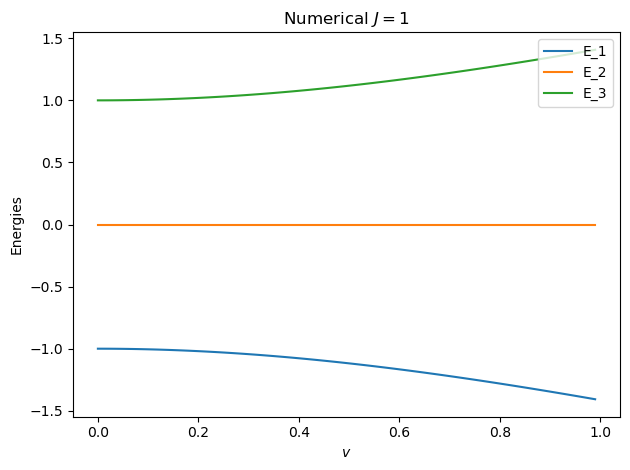

In [10]:
plot_2D(vs, eigs, plot_count=3, title=r"Numerical $J=1$", x_title=r'$v$', 
        label = [r'E_1', r'E_2', r'E_3'], y_title='Energies')

### VQE



In [11]:
def H(v): 
    return PauliSumOp.from_list([('ZI', (0.5 * eps)),
                                 ('IZ', (0.5 * eps)), 
                                 ('YY', (-0.5 * v)),
                                 ('XX', (0.5 * v))])

H(0)

PauliSumOp(SparsePauliOp(['ZI', 'IZ', 'YY', 'XX'],
              coeffs=[ 0.5+0.j,  0.5+0.j, -0. +0.j,  0. +0.j]), coeff=1.0)

Set up

In [12]:
def ansatz():
    '''creates an ansatz for vqe
    inputs:
        n: int, number of qubits
    return:
        qc: QuantumCircuit object, parametrized quantum circuit with given number of qubits, with parameters 
        thetas and phis
        '''
    n=2
    qc = QuantumCircuit(n)
    theta0 = Parameter('theta0')
    phi0 = Parameter('phi0')
    theta1 = Parameter('theta1')
    phi1 = Parameter('phi1')

    qc.rx(theta0,0)
    qc.ry(phi0,0)
    qc.rx(theta1,1)
    qc.ry(phi1,1)
    qc.cnot(0,1)
    
    return qc

def prep_vqe(n):
    '''input:
        n: int, number of qubits'''
    adam = ADAM(maxiter = 10000)
    slsqp = SLSQP(maxiter = 10000)
    # backend = Aer.get_backend('qasm_simulator')
    estimator = Estimator()

    vqe = VQE(ansatz=ansatz(), 
              optimizer=slsqp, 
              initial_point=np.random.uniform(low=-np.pi, high=np.pi, size=2*n), 
              estimator=estimator)

    return vqe
# vqe is sucessful becuase we enbed 2 qubit gates which, which creates highly entangled states. 
# Allowing us to explore multiple states at the same time. thetas needed for an n_qubit state doesn't have to scale exponentially with the number of qubits, but only linearly.


# def get_energy(angles, v, number_shots, target = None):
#     theta0, phi0, theta1, phi1 = angles
    
#     init_state = prepare_state(theta0, phi0, theta1, phi1, target)
#     qubit = Two_qubit()

#     ZI = np.kron(qubit.Z, qubit.I)

#     qubit.set_state(init_state)
#     qubit.apply_swap() # rotate measurement basis
#     measure_iz = qubit.measure(number_shots)

#     qubit.set_state(init_state)
#     measure_zi = qubit.measure(number_shots)
    
#     qubit.set_state(init_state)
#     qubit.apply_hadamard(0)
#     qubit.apply_hadamard(1)
#     qubit.apply_cnot10() # rotate measurement basis
#     measure_xx = qubit.measure(number_shots)
    
#     qubit.set_state(init_state)
#     qubit.apply_sdag(0)
#     qubit.apply_hadamard(0)
#     qubit.apply_sdag(1)
#     qubit.apply_hadamard(1)
#     qubit.apply_cnot10() # rotate measurement basis
#     measure_yy = qubit.measure(number_shots)
    

#     # expected value of ZI = (#00 + #01 - #10 - #11)/ number of shots
#     exp_vals = np.zeros(4) # do not include the expectation value of II
#     measures = np.array([measure_iz, measure_zi, measure_xx, measure_yy])
#     constants = np.array([1/2, 1/2, -v/2, v/2])
#     for index in range(len(exp_vals)):
#         counts = [len(np.where(measures[index] == i)[0]) for i in range(4)]
#         exp_vals[index] = counts[0] + counts[1] - counts[2] - counts[3]

#     exp_val = np.sum(constants * exp_vals) / number_shots
#     return exp_val


In [13]:
n_points=100
n_qubits=2

vs = np.arange(n_points) # rmb to divide when used
vqe = prep_vqe(n_qubits)
energies = np.zeros(n_points) # containers for the energies

for i, v in enumerate(vs):
    v = v / n_points
    ham = H(v)
    print(ham)
    result = vqe.compute_minimum_eigenvalue(ham)
    energies[i] = result.eigenvalue.real
    print(f'v = {v}, energy = {result.eigenvalue.real}')




0.5 * ZI
+ 0.5 * IZ
+ -0.0 * YY
+ 0.0 * XX
v = 0.0, energy = -0.9999999381679525
0.5 * ZI
+ 0.5 * IZ
- 0.005 * YY
+ 0.005 * XX
v = 0.01, energy = -1.000049976118848
0.5 * ZI
+ 0.5 * IZ
- 0.01 * YY
+ 0.01 * XX
v = 0.02, energy = -1.0001999800000978
0.5 * ZI
+ 0.5 * IZ
- 0.015 * YY
+ 0.015 * XX
v = 0.03, energy = -1.0004498359738243
0.5 * ZI
+ 0.5 * IZ
- 0.02 * YY
+ 0.02 * XX
v = 0.04, energy = -1.0007996502167253
0.5 * ZI
+ 0.5 * IZ
- 0.025 * YY
+ 0.025 * XX
v = 0.05, energy = -1.001249216040512
0.5 * ZI
+ 0.5 * IZ
- 0.03 * YY
+ 0.03 * XX
v = 0.06, energy = -1.001798330731275
0.5 * ZI
+ 0.5 * IZ
- 0.035 * YY
+ 0.035 * XX
v = 0.07, energy = -1.002446817686758
0.5 * ZI
+ 0.5 * IZ
- 0.04 * YY
+ 0.04 * XX
v = 0.08, energy = -1.0031948740988443
0.5 * ZI
+ 0.5 * IZ
- 0.045 * YY
+ 0.045 * XX
v = 0.09, energy = -1.0040418265352746
0.5 * ZI
+ 0.5 * IZ
- 0.05 * YY
+ 0.05 * XX
v = 0.1, energy = -1.0049874876703035
0.5 * ZI
+ 0.5 * IZ
- 0.055 * YY
+ 0.055 * XX
v = 0.11, energy = -1.0060315283181986

In [14]:
# plt.plot(vs/n_points, energies)
# plt.plot(vs/n_points, eigs[0])
plot_2D(vs/n_points, [energies, eigs[0]], plot_count=2, title="Ground state energies", x_title=r'$\lambda$', y_title='Energy', label=['vqe-qk', 'eigensolver'],
        filename='lipkin-2.pdf'), 
# save_fig('qk-1qb.pdf')
plt.show()

With **src.base**
$$
\begin{aligned}
H &= H_0 + H_1 \\
&= \frac{1}{2} (Z_1 + Z_2) + \frac{1}{2} V (X_1 \otimes X_2 + Y_1 \otimes Y_2)
\end{aligned}

In [1109]:

def my_ansatz(params):
    '''params: list of parameters for the ansatz, [thetas, phis]'''
    qc = Qubits_2()
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    qc.rx(params[2], 1)
    qc.ry(params[3], 1)
    qc.cnot(0, 1)
    return qc

def my_H(v):
    return pauli_sum([('ZI', (0.5 * eps)),
                      ('IZ', (0.5 * eps)), 
                      ('YY', (-0.5 * v)),
                      ('XX', (0.5 * v))])


def expectation(qc, v, n_shots=10000):
    '''the expectation value of energy for the hamiltonian'''
    coeffs = {'IZ':0.5 * eps, 'ZI': 0.5 * eps, 'XX':0.5 * v, 'YY':-0.5 * v}

    # IZ
    qc_copy = qc.copy()
    qc_copy.swap() 
    count_iz = qc_copy.measure(n_shots=n_shots)[:,0] # only the couonts, don't keep the states

    # ZI
    qc_copy = qc.copy() # make a new copy everytime
    count_zi = qc_copy.measure(n_shots=n_shots)[:,0]

    # XX
    qc_copy = qc.copy()
    qc_copy.hadamard(0)
    qc_copy.hadamard(1)
    qc_copy.cnot(1,0)
    count_xx = qc_copy.measure(n_shots=n_shots)[:,0]

    # YY
    qc_copy = qc.copy()
    qc_copy.sdag(0)
    qc_copy.hadamard(0)
    qc_copy.sdag(1)
    qc_copy.hadamard(1)
    qc_copy.cnot(1,0)
    count_yy = qc_copy.measure(n_shots=n_shots)[:,0]

    expectation = 0
    # ZI = (#00 + #01 - #10 - #11)/ number of shots
    # print(count_iz, count_zi, count_zz, count_xx)
    counts = [coeffs['IZ'] * count_iz, coeffs['ZI'] * count_zi, 
              coeffs['YY'] * count_yy, coeffs['XX'] * count_xx]
    
    # print(counts)
    for count in counts:
        # print(count)
        for i, state_count in enumerate(count):
            if i < 2:
                expectation += state_count
            else:
                expectation -= state_count
    return expectation / n_shots


qc = Qubits_2()
v = np.random.uniform(-np.pi, np.pi)
a = qc.state.conj() @ my_H(v) @ qc.state
a, expectation(qc, v)


((1+0j), 0.9997969703939769)

In [16]:
a = my_ansatz(np.ones(4)* np.random.uniform(low=-np.pi/2, high=np.pi/2))
a

Qubit(s) in state: 
 0.24+0.47j|00⟩ + 0.49-0.12j|01⟩ + 0.00-0.47j|10⟩ + 0.49-0.12j|11⟩ 

In [17]:
from algorithms import Vqe 

In [18]:
n_points = 100

init_points = np.random.uniform(low=-np.pi, high=np.pi, size=4)
my_vqe = Vqe(my_ansatz, init_points, expectation=expectation)

my_energies = np.zeros(n_points)
vs = np.arange(n_points)
for i, v in enumerate(vs):
    v = v / n_points
    my_ham = my_H(v)
    # print(my_ham)
    min_params, min_energy = my_vqe.minimise_eigenvalue(my_ham, v, 10000)
    print(f"v: {v}, energy: {min_energy}")
    my_energies[i] = min_energy



v: 0.0, energy: -1.0
v: 0.01, energy: -1.000303
v: 0.02, energy: -1.0004400000000002
v: 0.03, energy: -1.000554
v: 0.04, energy: -1.0012999999999999
v: 0.05, energy: -1.0022149999999999
v: 0.06, energy: -0.999714
v: 0.07, energy: -1.002874
v: 0.08, energy: -1.003896
v: 0.09, energy: -1.003815
v: 0.1, energy: -1.0055100000000001
v: 0.11, energy: -1.0077749999999996
v: 0.12, energy: -1.0052759999999996
v: 0.13, energy: -1.0093830000000001
v: 0.14, energy: -1.0109139999999999
v: 0.15, energy: -1.00954
v: 0.16, energy: -1.011772
v: 0.17, energy: -1.0159189999999998
v: 0.18, energy: -1.0183899999999997
v: 0.19, energy: -1.0181689999999999
v: 0.2, energy: -1.0201200000000001
v: 0.21, energy: -1.0256589999999999
v: 0.22, energy: -1.0260319999999998
v: 0.23, energy: -1.0251849999999998
v: 0.24, energy: -1.0293080000000001
v: 0.25, energy: -1.031325
v: 0.26, energy: -1.035934
v: 0.27, energy: -1.0376850000000002
v: 0.28, energy: -1.0401600000000002
v: 0.29, energy: -1.043202
v: 0.3, energy: -1.

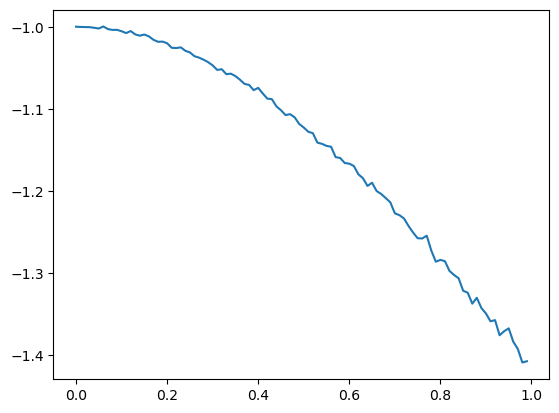

In [19]:
plt.plot(vs/n_points, my_energies)
plt.show()

In [20]:
plot_2D(vs/n_points, [energies, eigs[0], my_energies], plot_count=3, title="Ground state energies", x_title=r'$\lambda$', y_title='Energy', label=['vqe-qk', 'eigensolver', 'vqe-base']
        ,filename='lipkin-2.pdf'), 


(None,)

### J=2

In [1117]:

# def H(V):
#     return np.array([[-2*eps, 0, np.sqrt(6)*V, 0, 0],
#                   [0, -eps, 0, 3*V, 0],
#                   [np.sqrt(6)*V, 0, 0, 0, np.sqrt(6)*V],
#                   [0, 3*V, 0, eps, 0],
#                   [0, 0, np.sqrt(6)*V, 0, 2*eps]])

# H(0)

def my_H(v):
    x_coeff = -v/2
    y_coeff = v/2
    return pauli_sum([('ZIII', 0.5), ('IZII', 0.5), ('IIZI', 0.5), ('IIIZ', 0.5), # all 1 qubit combinations
                      ('XXII', x_coeff), ('XIXI', x_coeff), ('XIIX', x_coeff), ('IXXI', x_coeff), ('IXIX', x_coeff), ('IIXX', x_coeff), # all 2 qubit combinations
                      ('YYII', y_coeff), ('YIYI', y_coeff), ('YIIY', y_coeff), ('IYYI', y_coeff), ('IYIY', y_coeff), ('IIYY', y_coeff)])

my_H(0)

array([[ 2.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
         0.+0

In [922]:
vs = np.arange(0, 2, 0.01)
eigs = np.zeros((16, len(vs)))


for i, v in enumerate(vs):
    ham = my_H(v)
    eigvals, eigvecs = np.linalg.eig(my_H(v))
    eigs[:,i] = sorted(eigvals)

/var/folders/jg/t3sh6cf540j_h6jc8c4mssl40000gn/T/ipykernel_80146/4160433372.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  eigs[:,i] = sorted(eigvals)


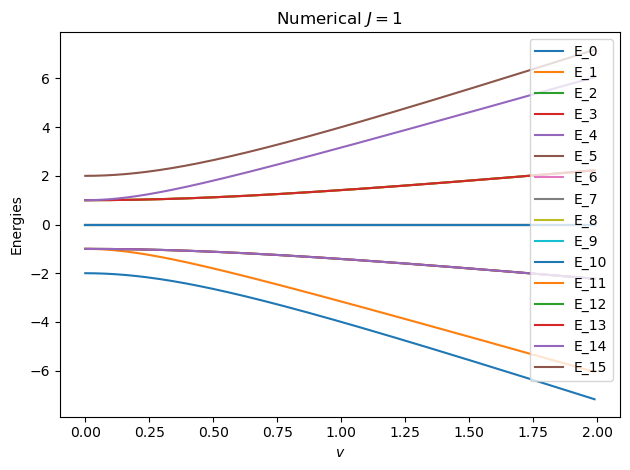

In [923]:
plot_2D(vs, eigs, plot_count=16, title=r"Numerical $J=1$", x_title=r'$v$', 
        label = [rf'E_{i}' for i in range(16)], y_title='Energies')

As we can see, every eigenvalue has a degenerate value. However $E_3$ and $E_{14}$ are energy eigenvalues that we do not get from the 5x5 matrix. 

In [1119]:
def ansatz():
    # Create a 4-qubit quantum circuit
    circuit = QuantumCircuit(4)

    # Define Parameter objects for theta and phi
    theta_params = [Parameter('theta{}'.format(i)) for i in range(4)]
    phi_params = [Parameter('phi{}'.format(i)) for i in range(4)]

    # Apply parameterized Rx and Ry gates to each qubit
    for i in range(4):
        circuit.rx(theta_params[i], i)
        circuit.ry(phi_params[i], i)

    # Apply CNOT gates between neighboring qubits
    # circuit.ccx(0, 1, 2)
    circuit.h(0)
    circuit.cx(2, 3)
    circuit.cx(1, 2)
    circuit.cx(0, 1)
    
    # circuit.cx(0, 2)
    # circuit.cx(1, 3)
    # circuit.cx(0, 3)

    return circuit


def H(v):
    x_coeff = -v/2
    y_coeff = v/2
    return PauliSumOp.from_list([('ZIII', 0.5), ('IZII', 0.5), ('IIZI', 0.5), ('IIIZ', 0.5), # all 1 qubit combinations
                      ('XXII', x_coeff), ('XIXI', x_coeff), ('XIIX', x_coeff), ('IXXI', x_coeff), ('IXIX', x_coeff), ('IIXX', x_coeff), # all 2 qubit combinations
                      ('YYII', y_coeff), ('YIYI', y_coeff), ('YIIY', y_coeff), ('IYYI', y_coeff), ('IYIY', y_coeff), ('IIYY', y_coeff)])


In [1122]:

n_qubits=4

vs = np.arange(0,2,0.01) # rmb to divide when used
n_points=len(vs)
vqe = prep_vqe(n_qubits)
energies = np.zeros(n_points) # containers for the energies

for i, v in enumerate(vs):
    ham = H(v)
    # print(ham)
    result = vqe.compute_minimum_eigenvalue(ham)
    energies[i] = result.eigenvalue.real
    print(f'v = {v}, energy = {result.eigenvalue.real}')


v = 0.0, energy = -1.9999996572345913
v = 0.01, energy = -2.000150675677185
v = 0.02, energy = -2.0006077089099956
v = 0.03, energy = -2.001376786126866
v = 0.04, energy = -2.0024639691614445
v = 0.05, energy = -2.0038752358089438
v = 0.06, energy = -2.0056165965968074
v = 0.07, energy = -2.0076940042411096
v = 0.08, energy = -2.0101133521136347
v = 0.09, energy = -2.0128804555858104
v = 0.1, energy = -2.016001033200163
v = 0.11, energy = -2.019480686404693
v = 0.12, energy = -2.023324883036115
v = 0.13, energy = -2.027538540474096
v = 0.14, energy = -2.0321279360487132
v = 0.15, energy = -2.0370968500145055
v = 0.16, energy = -2.042449973483196
v = 0.17, energy = -2.048192888760828
v = 0.18, energy = -2.0543286619802643
v = 0.19, energy = -2.0608615988257495
v = 0.2, energy = -2.0677952544579954
v = 0.21, energy = -2.075132899767348
v = 0.22, energy = -2.082877455328342
v = 0.23, energy = -2.091031474045554
v = 0.24, energy = -2.099597127118655
v = 0.25, energy = -2.1085761881413743
v

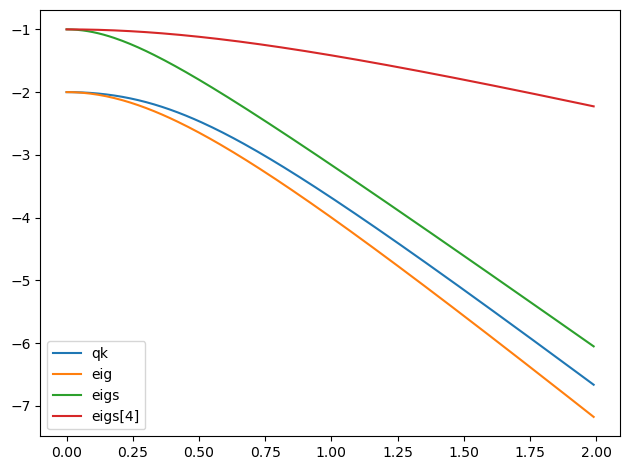

In [1123]:
plot_2D(vs, [energies,eigs[0],eigs[1], eigs[2]], plot_count=4, label=['qk', 'eig' ,'eigs', 'eigs[4]'])
plt.show()

In [1114]:
def my_ansatz(params):
    '''params: list of parameters for the ansatz, [thetas, phis, lambdas]'''
    qubits = Qubits(4)

    params = params.reshape(4,2)
    for i in range(4):
        theta = params[i, 0]
        phi = params[i, 1]
        qubits.rx(theta, i)
        qubits.ry(phi, i)

    # more complex pattern of CNOTs for entanglement
    toffoli = np.eye(8)
    toffoli[-2:, -2:] = np.array([[0, 1], [1, 0]])
    # qubits.state = np.kron(toffoli, qubits.I) @ qubits.state
    qubits.cnot(2, 3)
    qubits.cnot(1, 2)
    qubits.cnot(0, 1) 
    
    # qubits.cnot(0, 2)  # added
    # qubits.cnot(1, 3)  # added

    # print(qubits)
    return qubits



In [1198]:
q = Qubits(4)
SWAP, CNOT10, Sdag, h = q.swp, q.cnot_10, q.S.conj(), q.H
print(SWAP)
print(CNOT10)
print(Sdag)

measures = []
unitaries = []
U_ZIII = np.kron(I, np.kron(I, np.kron(I, I)))
unitaries.append(U_ZIII)
U_IZII = np.kron(np.kron(I, I)@SWAP, np.kron(I, I))
unitaries.append(U_IZII)
U_IIZI = U_IZII@np.kron(I, np.kron(np.kron(I, I)@SWAP, I))
unitaries.append(U_IIZI)
U_IIIZ = U_IIZI@np.kron(I, np.kron(I, np.kron(I, I)@SWAP))
unitaries.append(U_IIIZ)

U_ZIZI = np.kron(CNOT10, np.kron(I, I))@np.kron(I, np.kron(SWAP@np.kron(I, I), I))

U_XX = CNOT10@np.kron(h, h)
U_XI = np.kron(h, I)
U_IX = U_XI@SWAP
U_XXII = np.kron(U_XX, np.kron(I, I))
unitaries.append(U_XXII)
U_XIXI = U_ZIZI@np.kron(U_XI, U_XI)
unitaries.append(U_XIXI)
U_XIIX = U_ZIZI@np.kron(U_XI, U_IX)
unitaries.append(U_XIIX)
U_IXXI = U_ZIZI@np.kron(U_IX, U_XI)
unitaries.append(U_IXXI)
U_IXIX = U_ZIZI@np.kron(U_IX, U_IX)
unitaries.append(U_IXIX)
U_IIXX = U_IIZI@np.kron(I, np.kron(I, U_XX))
unitaries.append(U_IIXX)

U_YY = CNOT10@np.kron(h@Sdag, h@Sdag)
U_YI = np.kron(h@Sdag, I)
U_IY = U_YI@SWAP
U_YYII = np.kron(U_YY, np.kron(I, I))
unitaries.append(U_YYII)
U_YIYI = U_ZIZI@np.kron(U_YI, U_YI)
unitaries.append(U_YIYI)
U_YIIY = U_ZIZI@np.kron(U_YI, U_IY)
unitaries.append(U_YIIY)
U_IYYI = U_ZIZI@np.kron(U_IY, U_YI)
unitaries.append(U_IYYI)
U_IYIY = U_ZIZI@np.kron(U_IY, U_IY)
unitaries.append(U_IYIY)
U_IIYY = U_IIZI@np.kron(np.kron(I, I), U_YY)
unitaries.append(U_IIYY)
print(np.array(unitaries).shape)

[[1 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 1]]
[[1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]]
[[1.-0.j 0.-0.j]
 [0.-0.j 0.-1.j]]
(16, 16, 16)


In [1206]:
def expectation_2(qc, v, n_shots=1000):
    '''the expectation value of energy for the hamiltonian'''
    x_coeff = -v/2
    y_coeff = v/2
    coeffs = {'ZIII': 0.5, 'IZII': 0.5, 'IIZI': 0.5, 'IIIZ': 0.5, # all 1 qubit combinations
               'XXII': x_coeff, 'XIXI': x_coeff, 'XIIX': x_coeff, 'IXXI': x_coeff, 'IXIX': x_coeff, 'IIXX': x_coeff, # all 2 qubit combinations
               'YYII': y_coeff, 'YIYI': y_coeff, 'YIIY': y_coeff, 'IYYI': y_coeff, 'IYIY': y_coeff, 'IIYY': y_coeff}

    swaps = {'IIIZ': [(3,0)], 'IIZI': [(2,0)], 'IZII': [(1,0)],
             'XXII': [], 'XIXI': [(1, 2)], 'XIIX': [(1, 3)], 'IXXI': [(0, 2)], 'IXIX': [(0, 3)], 'IIXX': [(0, 2), (1, 3)], 
             'YYII': [], 'YIYI': [(1, 2)], 'YIIY': [(1, 3)], 'IYYI': [(0, 2)], 'IYIY': [(0,3)], 'IIYY': [(0, 2), (1, 3)]}
    
    # print(qc)
    counts = np.zeros((16, 16))
        
    for i, operators in enumerate(coeffs.keys()):

        qc_copy = qc.copy()

        if operators == 'ZIII':
            counts[i] = qc_copy.measure(n_shots)[:, 0]
            continue

        for pair in swaps[operators]:
            qc_copy.swap(pair[0], pair[1])
            #print(qc_copy)
        if 'X' in operators:

            qc_copy.cnot(1, 0)  
            for j in range(2):   
                # print(qc_copy.state.shape)
                qc_copy.hadamard(j)
                
        elif 'Y' in operators:
            # print("y \n", operators)
            qc_copy.cnot(1,0)
            for j in range(2):
                qc_copy.sdag(j)
                qc_copy.hadamard(j)
            
        
        counts[i] = qc_copy.measure(n_shots)[:, 0]
        # print(operators, counts[i])
    
    # print(counts/n_shots)
    exp_val = 0
    coeffs_z = 0.5 * np.ones(4)
    coeffs_x = -0.5*v*np.ones(6)
    coeffs_y = 0.5*v*np.ones(6)
    coeffs = np.concatenate((coeffs_z, coeffs_x, coeffs_y))
    counts *= coeffs
    # counts = counts * np.array(list(coeffs.values()))
    # print(counts.shape)
    # print(coeffs.values())
    for count in counts:
        # print(count)
        for i, state_count in enumerate(count):
            # print(i ,state_count)
            if i < 8:
                exp_val += state_count
            else:
                exp_val -= state_count
    # print(exp_val)
    return  exp_val / n_shots


def exp_mt(qc, v, n_shots=1000):

    exp_val = 0
    coeffs_z = 0.5 * np.ones(4)
    coeffs_x = -0.5*v*np.ones(6)
    coeffs_y = 0.5*v*np.ones(6)
    coeffs = np.concatenate((coeffs_z, coeffs_x, coeffs_y))
    
    counts = np.zeros((16, 16))
    for i, u in enumerate(unitaries):
        qc_copy = qc.copy()
        qc_copy.state = u @ qc_copy.state
        counts[i] = qc_copy.measure(n_shots)[:, 0]

    counts *= coeffs
    # print(counts)
    exp_vals = np.zeros((16,16)) 
    for index in range(len(exp_vals)):
        for outcome, count in enumerate(counts):
            if outcome <= 7:
                exp_vals[index] += count #the first 8 outcomes correspond to 0 in the first qubit
            elif outcome > 7:
                exp_vals[index] -= count #the last 8 outcomes correspond to 1 in the first qubit
    exp_val =  np.sum(exp_vals) / n_shots

    return exp_val


a, qc
#print(qc.swap(3,0))
test = 0.5
for _ in range(10):
    # a = np.random.uniform(low=-np.pi, high=np.pi, size=(4, 2))
    a = np.zeros((4,2))
    qc = my_ansatz(a)
    ex = qc.state.conj() @ my_H(test) @ qc.state
    b, c = expectation_2(qc, test, 10000), exp_mt(qc, test, 10000)
    print(f"{ex.real:.3f}, {b:.3f}, {c:.3f}")

2.000, 2.752, 25.827
2.000, 2.740, 26.023
2.000, 2.768, 25.959
2.000, 2.765, 26.012
2.000, 2.755, 26.161
2.000, 2.753, 26.116
2.000, 2.755, 26.426
2.000, 2.747, 26.005
2.000, 2.750, 26.125
2.000, 2.729, 26.200


In [830]:
n_points = 10
# print(Vqe)

init_points = np.random.uniform(low=-np.pi, high=np.pi, size=(4,2))
my_vqe = Vqe(my_ansatz, init_points, expectation=expectation_2)
# my_vqe = Vqe(my_ansatz, init_points)
# print(my_vqe)
my_energies = np.zeros(n_points)
vs = np.linspace(0, 2, n_points)
for i, v in enumerate(vs):
    v = v / n_points
    my_ham = my_H(v)
    # print(my_ham)
    min_params, min_energy = my_vqe.minimise_eigenvalue(my_ham, v, 1000)
    print(f"v: {v}, energy: {min_energy}")
    my_energies[i] = min_energy


v: 0.0, energy: 0.0
v: 0.02222222222222222, energy: -0.17775555555555553
v: 0.04444444444444444, energy: -0.35551111111111106
v: 0.06666666666666667, energy: -0.5333333333333334
v: 0.08888888888888888, energy: -0.7111111111111111
v: 0.11111111111111112, energy: -0.8888888888888893
v: 0.13333333333333333, energy: -1.0666666666666667
v: 0.15555555555555553, energy: -1.244288888888889
v: 0.17777777777777776, energy: -1.4222222222222223
v: 0.2, energy: -1.5982000000000003


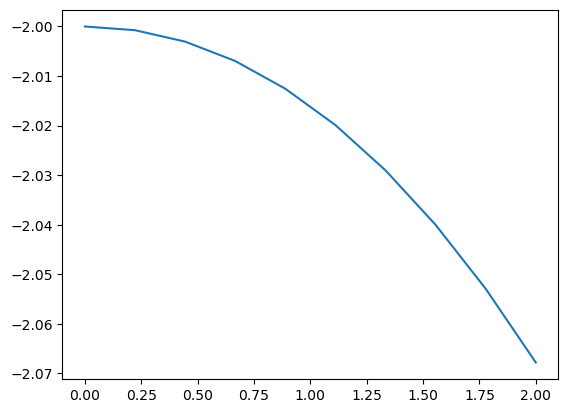

In [821]:
plt.plot(vs, my_energies)
plt.show()